In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex

In this notebook we first preform a basic exploratory analysis of the data contained in the metadata associated to the papers.
Then we look at changes in participation accross the years,

In [2]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])

In [3]:
metadata['subject'] =metadata.subject.map(lambda x: 
                     [i.strip() for i in regex.sub("'|\[|\]",'', str(x)).split(',') if len(i) > 0])

In [4]:
metadata.shape

(4230, 16)

In [5]:
metadata.head(2)

,file,subject,iso,uri,type,publisher,title,issued,accessioned,citation,available,abstract,long_name,author_order,shortend_names,identifier
0,2014_440-447,[],en,https://doi.dx.org/10.22318/icls2014.440,Book chapter,"Boulder, CO: International Society of the Lear...",Shared Epistemic Agency and Agency of Individu...,2014-06-01,2018-05-21 22:08:50+00:00,"Damşa, C. (2014). Shared Epistemic Agency and...",2018-05-21 22:08:50+00:00,This paper aims to clarify the concept of shar...,"Damşa, Crina",0,Damşa C.,"Damşa, C. (2014)"
1,2014_527-534,[],en,https://doi.dx.org/10.22318/icls2014.527,Book chapter,"Boulder, CO: International Society of the Lear...",Using Analytics for Improving Implementation F...,2014-06-01,2018-05-21 22:08:51+00:00,"Feng, M., Roschelle, J., Murphy, R., & Heffern...",2018-05-21 22:08:51+00:00,The field of learning analytics is rapidly dev...,"Feng, Mingyu",0,Feng M.,"Feng, M., Roschelle, J., Murphy, R., & Heffern..."


The following gives a good overview of the type of values we have in the dataset. The first column gives us the number of values. We can discover NaN values present in the dataset. We see that we ave Nan values in the subject and the abstract column.
We can also see the number of unique values in the second column. We see that long name and shortend name have different amounts of unique values. This means we should use the long name instead. 

In [6]:
#metadata[metadata.abstract.isna()].file.to_csv('NO_abstract_files.csv')
metadata[metadata.abstract.isna()].file.head()

82     2014_1615-1616
121    2014_1237-1246
182    2014_1709-1708
191    2014_1561-1562
197    2014_1709-1709
Name: file, dtype: object

In [7]:
metadata.count()

file              4230
subject           4230
iso               4230
uri               4230
type              4230
publisher         4230
title             4230
issued            4230
accessioned       4230
citation          4230
available         4230
abstract          4167
long_name         4230
author_order      4230
shortend_names    4230
identifier        4203
dtype: int64

In [8]:
metadata[~metadata.file.duplicated()].count()

file              1125
subject           1125
iso               1125
uri               1125
type              1125
publisher         1125
title             1125
issued            1125
accessioned       1125
citation          1125
available         1125
abstract          1092
long_name         1125
author_order      1125
shortend_names    1125
identifier        1124
dtype: int64

Something is wrong with the citation here:

In [9]:
metadata[metadata['identifier'].isna()].file.unique()

array(['2018_274'], dtype=object)

In [10]:
mask_keywords = (metadata.subject.map(len) == 0)
metadata[mask_keywords].file.drop_duplicates().shape

(359,)

Number of unique authors

In [11]:
len(metadata.long_name.unique())

2420

**Looking more into the naming issue**


We construct an index corresponding to each unique name, for both long and short form. Then, we merge long and short. Where both don't overlap, there is some issue with the naming.

Inspeciting the dataframe one finds that there are two cases: 
- small changes in the string make two identical names non identical.
- the citation order is out of order, and this the short form (based on the citation) was assigned incorrectly.
- the short form name is not unique

We can fix the small changes in naming issue when we build to graph of coauthor ship and then look at coauthors that are located in a similar place in the graph and that have similar names. 

In [12]:
unique_long = metadata.long_name.drop_duplicates()
unique_short = metadata.shortend_names.drop_duplicates()
names = metadata[['long_name', 'shortend_names']].drop_duplicates()

index_long = unique_long.reset_index()
index_short = unique_short.reset_index()
names = pd.merge(index_long,names, on='long_name')

differences = pd.merge(index_short, names, on='shortend_names')
differences[differences.index_x != differences.index_y].sample()

,index_x,shortend_names,index_y,long_name
913,1164,Linn M. C.,578,"Linn, Marcia"


In [13]:
differences[differences.shortend_names == 'Flood V. J.']

,index_x,shortend_names,index_y,long_name
80,80,Flood V. J.,80,"Flood, Virginia J."


We can fix the first problem by transforming the long form of the string. Now only issue 2 and 3 remain:

In [14]:
import unicodedata

In [15]:
unique_long = metadata.long_name.map(lambda x: regex.sub('\.', '',x)).drop_duplicates()
unique_long = unique_long.map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('ascii'))

unique_short = metadata.shortend_names.drop_duplicates()
names = metadata[['long_name', 'shortend_names']].drop_duplicates()

index_long = unique_long.reset_index()
index_short = unique_short.reset_index()
names = pd.merge(index_long,names, on='long_name')

differences = pd.merge(index_short, names, on='shortend_names')
differences[differences.index_x != differences.index_y].sample(5)

,index_x,shortend_names,index_y,long_name
1397,2535,Williams J. J.,1678,"Williams, Joseph"
836,1340,Halverson E. R.,3225,"Halverson, Erica Rosenfeld"
1192,2078,Clegg T. L.,124,"Clegg, Tamara"
377,529,Tong Y.,3627,"Tong, Yurui"
1270,2266,Carney M.,2518,"Carney, Michele"


In [16]:
differences[differences.shortend_names =='Tan E.'], differences[differences.shortend_names =='Roy D.']

(     index_x shortend_names  index_y    long_name
 279      372         Tan E.      372  Tan, Esther
 280      372         Tan E.     1075    Tan, Edna,
       index_x shortend_names  index_y long_name
 1645     3079         Roy D.     3079  Roy, Dan
 1646     3079         Roy D.     3939  Roy, Deb)

Use the cleaned long name string:

In [17]:
metadata.loc['long_name'] = metadata.long_name.map(lambda x: regex.sub('\.', '',x)).map(
    lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('ascii'))

# Looking at the authors:

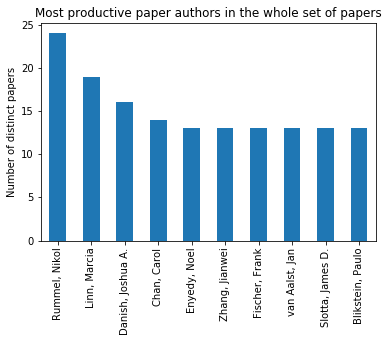

In [18]:
plt.title('Most productive paper authors in the whole set of papers')
plt.ylabel('Number of distinct papers')
metadata.long_name.value_counts().head(10).plot(kind = 'bar')
plt.show()

# Looking at the number of papers: 

We see that more papers get published in ICLS than in CLCS.

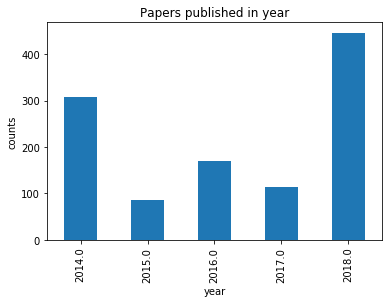

In [19]:
metadata['issued'] = metadata.issued.map(lambda x: x.year)
plt.title('Papers published in year')
plt.xlabel('year')
plt.ylabel('counts')
metadata[~metadata.file.duplicated()].issued.value_counts().sort_index().plot(kind='bar')
plt.show()

Here we look at the number of authors in each year:

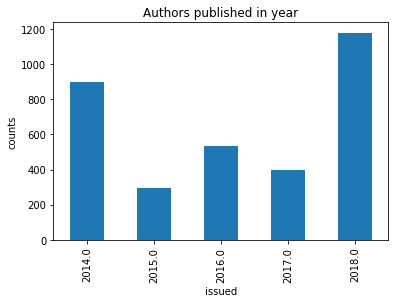

In [20]:
plt.title('Authors published in year')
plt.xlabel('year')
plt.ylabel('counts')
metadata.groupby(['issued']).long_name.unique().map(lambda x: len(x)).plot(kind = 'bar')

In each year, every author published the following average papers:

In [21]:
metadata.groupby('issued').long_name.value_counts().groupby('issued').mean()

issued
2014.0    1.306920
2015.0    1.242321
2016.0    1.231638
2017.0    1.167920
2018.0    1.338148
Name: long_name, dtype: float64

In [22]:
metadata.groupby('issued').long_name.value_counts().groupby('issued').median()

issued
2014.0    1
2015.0    1
2016.0    1
2017.0    1
2018.0    1
Name: long_name, dtype: int64

The median and average number of authors per paper is:

In [23]:
print("Median number authors per paper {}, Average number of authors per paper {:.4}".format(metadata.file.value_counts().median(), metadata.file.value_counts().mean()))

Median number authors per paper 3.0, Average number of authors per paper 3.76


In [24]:
metadata.groupby('issued').file.value_counts().groupby('issued').describe()

,count,mean,std,min,25%,50%,75%,max
issued,,,,,,,,
2014.0,308.0,3.801948,2.870108,1.0,2.0,3.0,5.0,18.0
2015.0,85.0,4.282353,3.227898,1.0,2.0,3.0,5.0,18.0
2016.0,171.0,3.824561,2.799934,1.0,2.0,3.0,4.5,20.0
2017.0,115.0,4.052174,3.521472,1.0,2.0,3.0,4.0,24.0
2018.0,446.0,3.531390,3.007504,1.0,2.0,3.0,4.0,27.0


In [25]:
metadata.groupby('issued').file.value_counts().groupby('issued').std()

issued
2014.0    2.870108
2015.0    3.227898
2016.0    2.799934
2017.0    3.521472
2018.0    3.007504
Name: file, dtype: float64

In [26]:
metadata.groupby('issued').file.value_counts().groupby('issued').mean()

issued
2014.0    3.801948
2015.0    4.282353
2016.0    3.824561
2017.0    4.052174
2018.0    3.531390
Name: file, dtype: float64

In [27]:
import scipy.stats as stats

Check if the observed difference in average number of authors is significant:
it is not - however, our data might change with more years to observe!
(the difference between only one year of CLCS and ICLS has even higher p value)

In [28]:
stats.ttest_ind(metadata[metadata.issued%2 == 0].file.value_counts() ,metadata[metadata.issued%2 != 0].file.value_counts())

Ttest_indResult(statistic=-2.018624999649567, pvalue=0.04376353245425325)

People who submitted every year of the year:

In [29]:
#get universities by year
uni_year = metadata.groupby('issued').apply(lambda x: set(x['long_name']))

#get years in our dataset
years = uni_year.index.tolist()

#create a set of universities that have participated at some point
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

#now use odd and even years to determine universities that participated every year in either ICLS or CSCL

regulars = unis[0]
ICLS = all_
CSCL = all_
for i, x in enumerate(unis):
    regulars = regulars.intersection(x)
    
    if years[i] % 2 == 0:
        ICLS = ICLS.intersection(x)
    else:
        CSCL = CSCL.intersection(x)
ICLS, CSCL = ICLS.difference(CSCL), CSCL.difference(ICLS)

In [30]:
print('Number of people who submit every year: ', len(regulars))
regulars

Number of people who submit every year:  22


{'Acosta, Alisa',
 'Anderson, Emma',
 'Andrade-Lotero, Alejandro',
 'Arastoopour, Golnaz',
 'Borge, Marcela',
 'Dillenbourg, Pierre',
 'Linn, Marcia',
 'Matuk, Camillia',
 'Moher, Tom',
 'Oshima, Jun',
 'Oshima, Ritsuko',
 'Peppler, Kylie A',
 'Puntambekar, Sadhana',
 'Rosé, Carolyn Penstein',
 'Rummel, Nikol',
 'Shaffer, David Williamson',
 'Sharma, Kshitij',
 'Weinberger, Armin',
 'Yip, Jason',
 'Yoon, Susan',
 'Zhang, Jianwei',
 'van Aalst, Jan'}

People who only subitted to 2015 and 2017:

In [31]:
print('Number of CSCL only participants: ', len(CSCL))
#CSCL

Number of CSCL only participants:  59


In [32]:
print('Number of ICLS only participants: ', len(ICLS))
#ICLS_only #uncomment to see al 129 participants

Number of ICLS only participants:  82


## Analyzing the regulars

The metadata associated with the regulars:

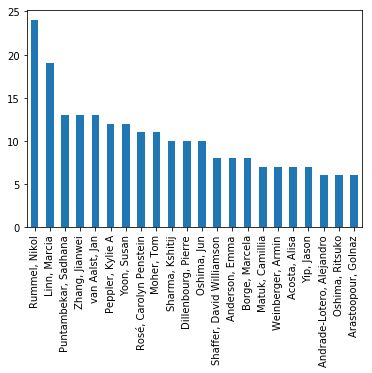

In [33]:
metadata[metadata.long_name.isin(regulars)].long_name.value_counts().plot(kind = 'bar')

Look at how number of pub. per year evolve ... there is not much to see:

In [34]:
regulars = pd.DataFrame(metadata[metadata.long_name.isin(regulars)].groupby('issued').long_name.value_counts())
regulars.columns = ['counts']
regulars.reset_index(inplace=True)

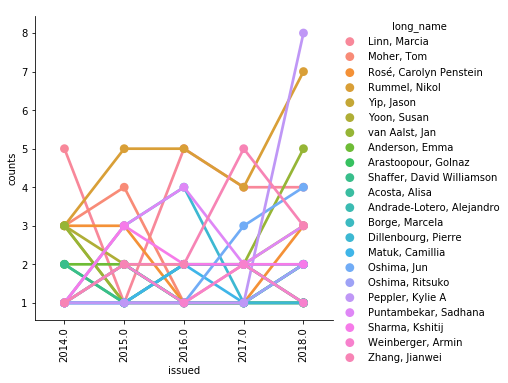

In [35]:
sns.catplot(data=regulars, x='issued', y='counts',kind='point', hue='long_name')
plt.xticks(rotation=90)
plt.show()

# looking at the keywords that come with the metadata:

In [36]:
all_keywords = metadata[(~metadata.file.duplicated())].subject.map(lambda x: str(x)).map(lambda x: regex.split(',', regex.sub("'|\[|\]", '', x).strip()))

In [37]:
pd.Series([i.strip().lower() for j in all_keywords.tolist() for i in j if len(i) > 0]).value_counts().head(20)

science education          51
design-based research      45
knowledge building         33
education technology       31
scaffolding                26
cscl                       22
collaborative learning     21
collaboration              21
design                     20
teacher education          18
technology                 17
interaction analysis       17
mathematics                17
online learning            17
science                    17
stem                       16
informal learning          16
argumentation              15
social network analysis    15
computer science           14
dtype: int64

In [38]:
metadata['subject'] = metadata.subject.map(
    lambda x: str(x)).map(lambda x: [i.strip() for i in regex.split(',', regex.sub("'|\[|\]", '', x).strip())])

In [39]:
metadata.subject[0]

['']

In [40]:
metadata[(metadata.issued == 2018)].file.drop_duplicates().shape[0]

446

In [41]:
len(all_keywords)==0

False

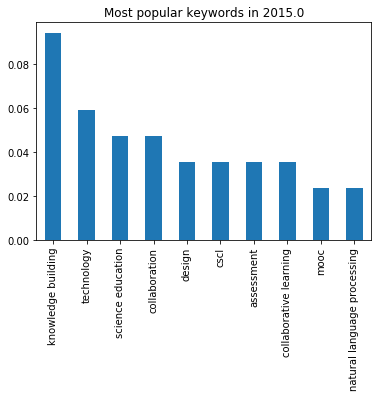

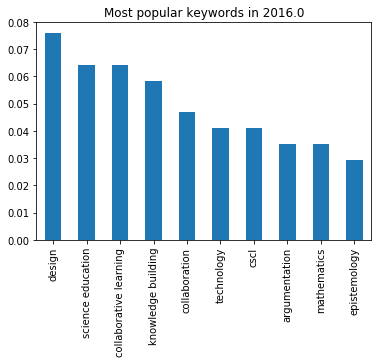

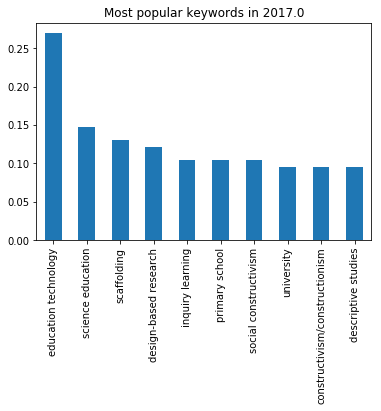

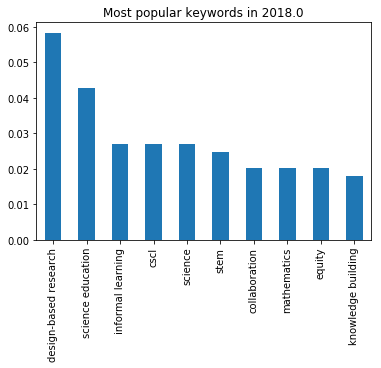

In [42]:
for year in sorted(metadata.issued.dropna().unique()) :
    all_keywords = metadata[(metadata.issued == year) & (~metadata.file.duplicated())].subject
    all_keywords = [i.strip().lower() for j in all_keywords.tolist() for i in j if len(i) > 0]
    if (len(all_keywords)==0) :
        continue
    plt.title('Most popular keywords in {}'.format(year))
    (pd.Series(all_keywords).value_counts() / 
     metadata[(metadata.issued == year)].file.drop_duplicates().shape[0]).head(10).plot(kind='bar')
    plt.show()

In [43]:
d = []
for year in sorted(metadata.issued.dropna().unique()) :
    all_keywords =  metadata[(metadata.issued == year) & (~metadata.file.duplicated())].subject
    print(all_keywords.shape, year)
    d.append(
        pd.DataFrame(pd.Series([i.strip().lower() for j in all_keywords.tolist() for i in j if len(i) > 0]).value_counts(), columns=[year])
    )


(308,) 2014.0
(85,) 2015.0
(171,) 2016.0
(115,) 2017.0
(446,) 2018.0


In [44]:
keywords_over_the_years = d[0].join(d[1], how='outer').join(d[2], how='outer').join(d[3], how='outer')

Number of symposiums will affect the average numver of keywords per paper, but we still present it here:

In [45]:
keywords_over_the_years.apply(lambda x: x.dropna().sum()) / metadata.groupby(['issued']).sum().author_order

2014.0    0.000000
2015.0    0.264734
2016.0    0.432704
2017.0    0.463329
2018.0         NaN
dtype: float64

Look at keywords making sure the normalize by the total counts for each year!

In [46]:
every_year = (keywords_over_the_years.dropna() / 
                           keywords_over_the_years.apply(lambda x: x.dropna().sum()) * 100 )

In [47]:
#exclude very small values for better plotting
every_year = every_year[every_year.apply(lambda x: (x > 0.8).any(), axis=1)]

In [48]:
melted_keywords = pd.melt(every_year.reset_index(), id_vars='index')

In [49]:
melted_keywords.rename(columns={'index': 'keyword', 'variable': 'year', 'value': 'occurence (%)'}, inplace=True)

In [50]:
melted_keywords

,keyword,year,occurence (%)


In [51]:
plt.figure(figsize=(10, 10))
sns.catplot(data=melted_keywords, x='year', y='occurence (%)', hue='keyword', kind='point')
plt.title('popularity of recurring keywords over the years')
plt.xticks(rotation=90)
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 720x720 with 0 Axes>